In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb


In [2]:
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [3]:
#choose location for plotting
ra0=0
dec0= -20

In [4]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 15.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=ra0, dec=dec0)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with constraint visitExposureTime > 15. for columns ['filter', 'fieldDec', 'fieldRA', 'observationStartMJD', 'seeingFwhmGeom', 'fiveSigmaDepth']
Found 2045493 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_15_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [8]:
dataSlice.dtype


dtype([('filter', '<U256'), ('fieldDec', '<f8'), ('fieldRA', '<f8'), ('observationStartMJD', '<f8'), ('seeingFwhmGeom', '<f8'), ('fiveSigmaDepth', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [9]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

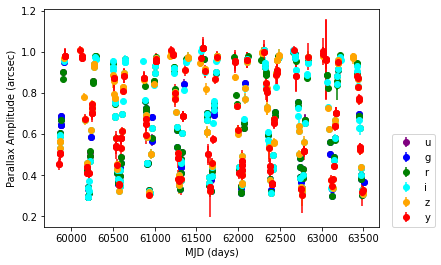

In [10]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [11]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

In [12]:
plot_base = """plot_baseline17_{plottype}_{ra}_{dec}.{ftype}"""


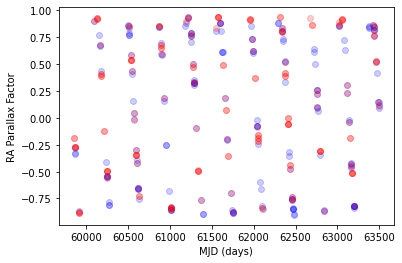

In [13]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plotname=plot_base.format(plottype='MJD_RAP',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)

In [14]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

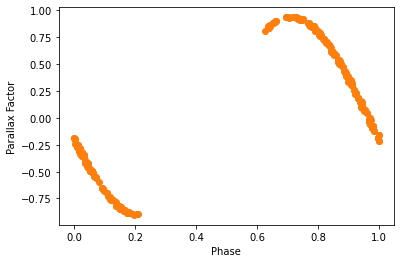

In [15]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)


In [16]:
np.size(dataSlice['ra_pi_amp'][izy])

345

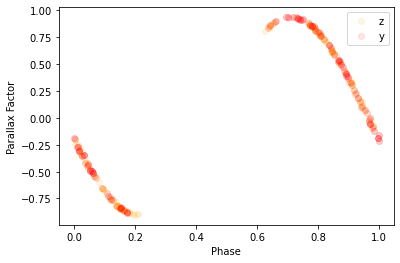

In [17]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.1,label='z')
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1,label='y')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');
plt.legend()
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)



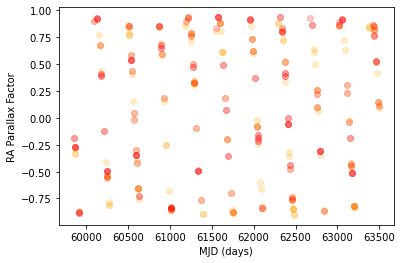

In [18]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')  
plotname=plot_base.format(plottype='MJD_RAP_zy',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)




In [19]:
print(np.max(dataSlice['ra_pi_amp'][iy]),np.min(dataSlice['ra_pi_amp'][iy]))

0.9346334664622917 -0.8810123379657313


In [20]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [21]:
parallax_table = Table()
parallax_table['MJD'] = dataSlice['observationStartMJD'][izy]
parallax_table['ra_pi_amp'] = dataSlice['ra_pi_amp'][izy]
parallax_table['dec_pi_amp'] = dataSlice['dec_pi_amp'][izy]
parallax_table['filter'] = dataSlice['filter'][izy]
parallax_table['seeingFWHM'] = dataSlice['seeingFwhmGeom'][izy]
parallax_table['snr'] = snr[izy]
parallax_table['position_errors'] = position_errors[izy]
parallax_table['fiveSigmaDepth'] = dataSlice['fiveSigmaDepth'][izy]
parallax_table['fieldRA'] = dataSlice['fieldRA'][izy]
parallax_table['fieldDec'] = dataSlice['fieldDec'][izy]




In [22]:
parallax_table

MJD,ra_pi_amp,dec_pi_amp,filter,seeingFWHM,snr,position_errors,fiveSigmaDepth,fieldRA,fieldDec
float64,float64,float64,str256,float64,float64,float64,float64,float64,float64
60546.34742500379,0.43141146214971865,-0.13580838567842154,z,0.7805987773504484,70.31504245434222,0.014941289921410257,22.870195597444948,358.86784245746026,-20.871191271359404
60546.36385683389,0.43118222413608903,-0.13594480331519557,y,0.7848953255411915,34.56796213593943,0.02481040306818985,22.09925943315603,358.86784245746026,-20.871191271359404
62338.31220136582,0.8068445821177149,0.1495239783979217,z,0.7452825212456351,84.57953466351648,0.013328338447512533,23.07073821774122,358.4183821711213,-20.883670139472088
62732.36429687774,0.4963147037773751,-0.09583837898463037,z,0.8436377079984321,67.77610283015616,0.015966787333526966,22.830266471672655,358.52933767520256,-20.93819069226807
63199.099580152855,-0.8394131440672249,-0.4677611145656993,z,0.7365486392930756,63.48264979563449,0.015317140325987301,22.759212604452227,358.6825542728054,-20.8330858111134
61248.2855901018,0.7636625666584078,0.10428076770757531,y,1.0385656790902231,26.147071885574075,0.04095962040332776,21.79613264137092,358.541018262455,-20.95326582617632
61248.26919296032,0.7638120633900733,0.10441927007059164,z,1.148184604600706,43.16738087103559,0.028416131605525544,22.340464237059404,358.541018262455,-20.95326582617632
62338.32959973757,0.8067073255775996,0.14938098224641067,y,1.2506074069587645,24.51606777015144,0.05198267179872452,21.726202022181937,358.4183821711213,-20.883670139472088
60217.249182268766,-0.11939881902004572,-0.39226105272676864,y,0.7621906537732028,28.114447077976685,0.028895804468664646,21.87489885599519,359.02665771989416,-20.875276455438698


In [23]:
from astropy.io import ascii

In [23]:
out_base = """data_baseline17_{datatype}_{ra}_{dec}.{ftype}"""
outname_tbl=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='tbl')
outname_csv=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='csv')


In [24]:
ascii.write(parallax_table,outname_tbl,format='ipac')

AttributeError: 'builtin_function_or_method' object has no attribute 'write'

In [ ]:
ascii.write(parallax_table,outname_csv,format='ecsv')

In [ ]:
plt.hist(parallax_table['ra_pi_amp'],bins=20,histtype='stepfilled', alpha=0.2, density=True)


In [ ]:
plt.hist(parallax_table['snr'],bins=20,histtype='stepfilled', alpha=0.2, density=True)



In [ ]:
plt.hist(parallax_table['fiveSigmaDepth'],bins=20,histtype='stepfilled', alpha=0.2, density=True)

